In [1]:
%matplotlib inline
import numpy as np
import main as main
import bayes as bayes
import matplotlib.pyplot as plt
import pymc
import mleNode as mn

Couldn't import dot_parser, loading of dot files will not be possible.


# Active Learning

(a) Comparing a star network between always choosing the main source and choosing a source uniformly at random

In [13]:
n_nodes = 5
n_cascades = 40
g = np.vstack((np.ones(n_nodes), np.zeros((n_nodes-1, n_nodes))))
g[0, 0] = 0
p = 0.5
g = np.log(1. / (1 - p * g))
cascades = main.simulate_cascades(n_cascades, g)

In [14]:
infected, susc = main.build_cascade_list(cascades)
model = bayes.mc_graph_setup(infected, susc)

In [27]:
mcmc = pymc.MCMC(model)
n_total = 1000
burn = 100
n_simul = n_total - burn
mcmc.sample(n_total, burn)

 [-----------------100%-----------------] 1000 of 1000 complete in 18.1 sec

In [28]:
def formatLabel(s, n):
    return '0'*(len(str(n)) - len(str(s))) + str(s)

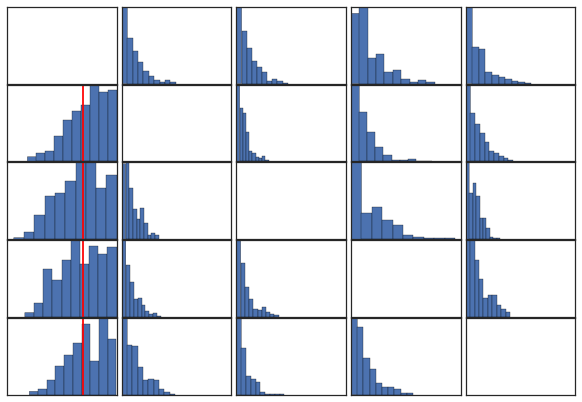

In [29]:
fig, ax = plt.subplots(len(g), len(g))
for i in xrange(len(g)):
    for j in xrange(len(g)):
        ax[i, j].get_xaxis().set_ticks([])
        ax[i, j].get_yaxis().set_ticks([])
        if i != j:
            it, jt = formatLabel(i, len(g)-1), formatLabel(j, len(g)-1)
            ax[i,j].hist(mcmc.trace('theta_{}{}'.format(it,jt))[:], normed=True)
            ax[i, j].set_xlim([0,1])
            ax[i, j].plot([g[j, i]]*2, [0, ax[i,j].get_ylim()[-1]], color='red')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=.1)
plt.show()

In [30]:
theta = np.empty((n_simul, n_nodes, n_nodes))
for i in xrange(len(g)):
    for j in xrange(len(g)):
        it, jt = formatLabel(i, len(g)-1), formatLabel(j, len(g)-1)
        theta[:, i, j] = mcmc.trace('theta_{}{}'.format(it, jt))[:]

- simulate cascades for each iteration of theta starting from specific source
- calculate the likelihood of each cascade 
- calculate the marginal probability of each cascade
- order nodes by difference

In [31]:
def specific_source(i, graph):
    x0 = np.zeros(graph.shape[0], dtype=bool)
    x0[i] = True
    return x0

In [33]:
infected, susceptible = [], []
rval = np.empty((theta.shape[0], theta.shape[1]))
for node in xrange(n_nodes):
    for i, graph in enumerate(theta):
        casc = main.simulate_cascades(10, graph, 
                                      source=lambda g, t: specific_source(node, g))
        x, s = main.build_cascade_list(casc, collapse=True)
        cond_lkl = main.cascadeLkl(graph, x, s)
        marg_lkl= np.mean([main.cascadeLkl(thet, x, s) for thet in theta])
        rval[i, node] = cond_lkl - marg_lkl
rval = rval.mean(axis=0)
print(rval)
print(np.argsort(rval))

[-0.02783062  0.02330009  0.02416332 -0.01541149  0.00959461]
[0 3 4 1 2]


# Error : the mutual information should always be positive